# Import libraries

In [1]:
import numpy as np
from scipy.spatial import KDTree
import os
import h5py
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
import matplotlib as mpl
from tqdm import tqdm
import seaborn as sns
from scipy import stats

# Set file paths

In [2]:
# Load TAHMO station data (CSV format with columns:'precipitation')
gmet_root_dir = r'C:\Users\c.kwa\Desktop\meteosat_retrieval\data_downloads\GMET\GMet_AWSdata\GMet_AWSdata'
#model_root_dir = r"D:\Ghana\Merged_files_IMERG_SEVIRI\Condition_set_0.02_20_all" 
model_root_dir = r'D:\Ghana\Merged_files_IMERG_SEVIRI\data_adapted_test_year\test' #r'Z:\cluster_projects\ro\1149_10\earthformer-multisource-to-inca\experiments_adapted130\repotest\testOutput'
#model_root_dir = r'D:\Ghana\Output_data\experiments_adapted130\repotest\testOutput'
#model_root_dir = r"D:/Ghana/Output_data/Earthformer_corrected/2022"

In [3]:
seviri_files = []
# Traverse through all subdirectories and files in the given path
for root, dirs, files in os.walk(model_root_dir):
    for file in files:
        if file.endswith(".hdf5"):
            seviri_files.append(os.path.join(root, file))

# Import GMET stationsdata

In [6]:
station_data_list_GMET = []
station_name_list_files = []
for station in os.listdir(gmet_root_dir):
    if station.endswith('.csv'):
        station_file = os.path.join(gmet_root_dir, station)
        station_data = pd.read_csv(station_file)
        station_data_list_GMET.append(station_data)
        station_name_list_files.append(station.split('.')[0])
        #display(station_data)

stations_meta_data_GMET = station_data_list_GMET.pop(7)
station_name_list = stations_meta_data_GMET['STN'].tolist()

station_data_gmet_dict = dict(zip(station_name_list, station_data_list_GMET))

for station_name in station_data_gmet_dict:
    # Convert 'timestamp' column to datetime format
    station_data_gmet_dict[station_name]['Timestamp'] = pd.to_datetime(
        station_data_gmet_dict[station_name]['Date'].astype(str) + ' ' + 
        station_data_gmet_dict[station_name]['Time'].astype(str),
        format='%m/%d/%Y %I:%M:%S %p'
    )
    # Set Timestamp as the index
    station_data_gmet_dict[station_name] = station_data_gmet_dict[station_name].set_index('Timestamp')
    # Drop the original Date and Time columns
    station_data_gmet_dict[station_name] = station_data_gmet_dict[station_name].drop(['Date', 'Time'], axis=1)

    # Ensure the column is numeric
    for col in station_data_gmet_dict[station_name].columns:
        station_data_gmet_dict[station_name][col] = pd.to_numeric(station_data_gmet_dict[station_name][col], errors='coerce')

        # Accumulate over 30 minutes
        station_data_gmet_dict[station_name] = station_data_gmet_dict[station_name].resample('30min', label = 'right', closed = 'right').sum(min_count = 2)

# Get the longitude latitude grid

In [7]:
# Load the SEVIRI file to get longitude latitude grid
file_name = 'MSG4-SEVI-MSG15-0100-NA-20200501001242.772000000Z-NA.hdf5'
file_path = fr'C:\Users\c.kwa\Desktop\meteosat_retrieval\SEVIRI_retrieval\Test_batch\Native_to_h5\hdf5\2020\05\{file_name}'
seviri_ds = xr.open_dataset(file_path, engine = 'netcdf4')

# Print dataset information (variables and dimensions)
grid_lat = seviri_ds['y'][:]  [::-1]
grid_lon = seviri_ds['x'][:]

grid_lat = grid_lat.values
grid_lon = grid_lon.values

# Create 2D latitude and longitude grids
grid_lon_2d, grid_lat_2d = np.meshgrid(grid_lon, grid_lat)

grid_lat_2d = np.flipud(grid_lat_2d)

### Define function to find nearest grid to stations

In [8]:
def nearest_grid_to_stations(grid_lat, grid_lon, station_lat, station_lon):
    """
    Map stations to nearest grid cells using KDTree.
    
    Parameters
    ----------
    grid_lat : numpy.ndarray
        Latitudes of grid cells.
    grid_lon : numpy.ndarray
        Longitudes of grid cells.
    station_lat : numpy.ndarray
        Latitudes of stations.
    station_lon : numpy.ndarray
        Longitudes of stations.
    
    Returns
    -------
    indices : numpy.ndarray
        Indices of grid cells nearest to each station.
    """
    grid_points = np.array(list(zip(grid_lat.ravel(), grid_lon.ravel())))
    station_points = np.array(list(zip(station_lat, station_lon)))
    tree = KDTree(grid_points)
    _, indices = tree.query(station_points)
    return indices

### Create dataframes of the nearest grid cell to stations of all the SEVIRI channels

In [8]:
indices = nearest_grid_to_stations(grid_lat_2d, grid_lon_2d, stations_meta_data_GMET['LAT'], stations_meta_data_GMET['LON'])

dt_list = np.empty(len(seviri_files), dtype=object)
seviri_station_cells = np.zeros((len(seviri_files), len(station_name_list), 11))

# Wrap the loop with tqdm for progress bar
for i, file in enumerate(tqdm(seviri_files, desc="Processing files")):
    try:
        time_str = os.path.basename(file).split('_')[1].split('.')[0]
        # Rearrange timestamp to match nearest timestamp of GMET stations (adjust as needed)
        dt_list[i] = datetime.strptime(time_str, "%Y%m%d%H%M%S") + timedelta(seconds=1)
        with h5py.File(fr'{file}', 'r') as f:
            seviri_data = f['SEVIRI'][-1, :, :, :]
    
            for channel in range(seviri_data.shape[2]):               
                    for k, grid_idx in enumerate(indices):
                        seviri_station_cells[i, k, channel] = np.flipud(seviri_data[:, :, channel]).flat[grid_idx]
                  
    except Exception as e:
        print(f"Error occurred while processing file {file}: {e}")
        for channel in range(seviri_data.shape[2]):
            for k, grid_idx in enumerate(indices):
                seviri_station_cells[i, k, channel] = np.nan

datetime_index = pd.DatetimeIndex(dt_list)
for channel in range(seviri_station_cells.shape[2]):
    df_seviri = pd.DataFrame(seviri_station_cells[:, :, channel], index=datetime_index, columns = station_name_list)
    df_seviri.to_csv(f'df_seviri_gmet_test_{channel}_2022.csv')

In [9]:
df_seviri_9 = pd.read_csv('df_seviri_gmet_test_8_2022.csv', index_col= 0, parse_dates= True)

In [10]:
df_seviri_6 = pd.read_csv('df_seviri_gmet_test_5_2022.csv', index_col= 0, parse_dates= True)

### Create correlation plots

Text(0.5, 1.0, 'Multivariate distribution of rainfall and brightness temperature')

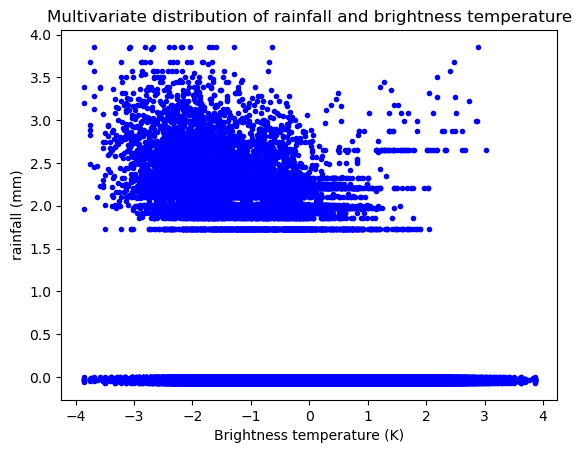

In [13]:
def unity(data):
    M = data.shape[0]  # Reading number of observations per node
    ranks = data.rank(axis=0)
    u_hat = ranks / (M + 1)
    return u_hat

def sd_normal(data):
    M = data.shape[0]  # Reading number of observations per node
    ranks = data.rank(axis=0)
    u_hat = ranks / (M + 1)
    sd_data = stats.norm.ppf(u_hat)
    return sd_data


for station_name in station_data_gmet_dict:
        # Merge the dataframes
        df = pd.concat([df_seviri_9[station_name], station_data_gmet_dict[station_name]], join='inner', axis=1)

        # Ensure numeric types for comparison
        #df[station_name] = pd.to_numeric(df[station_name], errors='coerce')
        df['Precipitation (mm)'] = pd.to_numeric(df['Precipitation (mm)'], errors='coerce')
        
        # Drop rows with NaN values after conversion
        df = df.dropna()
        plt.plot(sd_normal(df[station_name]), sd_normal(df['Precipitation (mm)']), 'b.')

plt.xlabel('Brightness temperature (K)')
plt.ylabel('rainfall (mm)')
plt.title('Multivariate distribution of rainfall and brightness temperature')
    


(0.0, 1.0)

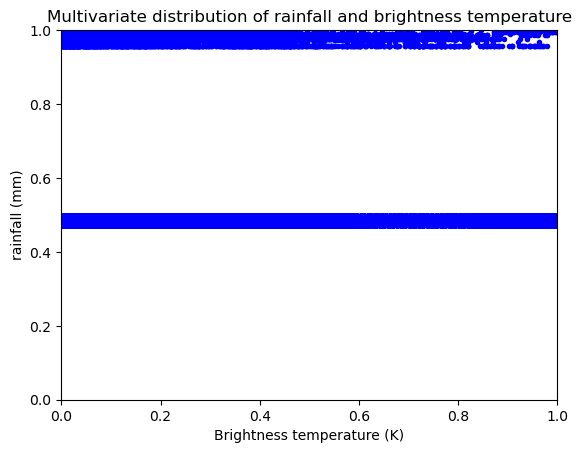

In [14]:
for station_name in station_data_gmet_dict:
        # Merge the dataframes
        df = pd.concat([df_seviri_9[station_name], station_data_gmet_dict[station_name]], join='inner', axis=1)

        # Ensure numeric types for comparison
        #df[station_name] = pd.to_numeric(df[station_name], errors='coerce')
        df['Precipitation (mm)'] = pd.to_numeric(df['Precipitation (mm)'], errors='coerce')
        
        # Drop rows with NaN values after conversion
        df = df.dropna()
        plt.plot(unity(df[station_name]), unity(df['Precipitation (mm)']), 'b.')

plt.xlabel('Brightness temperature (K)')
plt.ylabel('rainfall (mm)')
plt.title('Multivariate distribution of rainfall and brightness temperature')
plt.xlim(0, 1)
plt.ylim(0, 1)

skipping Abetifi
skipping Ada_Foah
skipping Jirapa
skipping Kalbeo
skipping Loagri
skipping Sefwi_Bekwai
skipping Tarkwa


(180.0, 350.0)

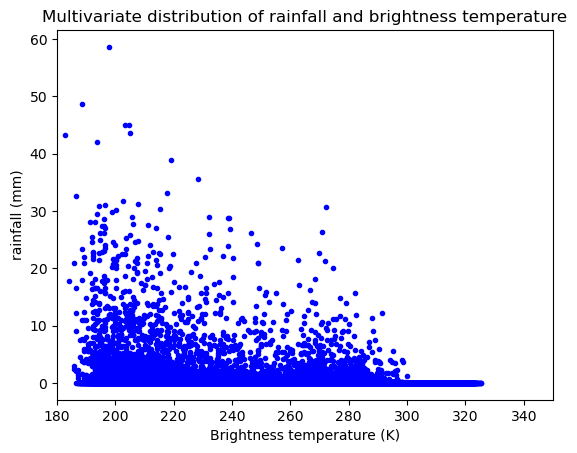

In [15]:
drop_data_gmet = ['Ada_Foah', 'Tarkwa', 'Abetifi', 'Sefwi_Bekwai', 'Loagri', 'Kalbeo', 'Jirapa']

for station_name in station_data_gmet_dict:
    if station_name not in drop_data_gmet:
            # Merge the dataframes
            df = pd.concat([df_seviri_9[station_name], station_data_gmet_dict[station_name]], join='inner', axis=1)
    
            # Ensure numeric types for comparison
            #df[station_name] = pd.to_numeric(df[station_name], errors='coerce')
            df['Precipitation (mm)'] = pd.to_numeric(df['Precipitation (mm)'], errors='coerce')
            
            # Drop rows with NaN values after conversion
            df = df.dropna()
            plt.plot(df[station_name], df['Precipitation (mm)'], 'b.')

    else:
        print(f'skipping {station_name}')

plt.xlabel('Brightness temperature (K)')
plt.ylabel('rainfall (mm)')
plt.title('Multivariate distribution of rainfall and brightness temperature')
plt.xlim(180, 350)

skipping Abetifi
skipping Ada_Foah
skipping Jirapa
skipping Kalbeo
skipping Loagri
skipping Sefwi_Bekwai
skipping Tarkwa


(180.0, 350.0)

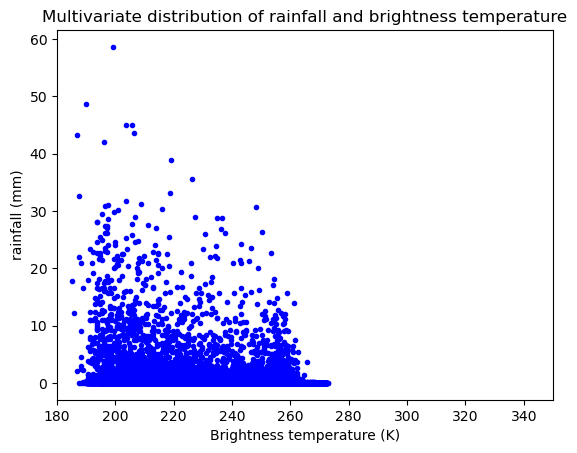

In [16]:
drop_data_gmet = ['Ada_Foah', 'Tarkwa', 'Abetifi', 'Sefwi_Bekwai', 'Loagri', 'Kalbeo', 'Jirapa']

for station_name in station_data_gmet_dict:
    if station_name not in drop_data_gmet:
            # Merge the dataframes
            df = pd.concat([df_seviri_6[station_name], station_data_gmet_dict[station_name]], join='inner', axis=1)
    
            # Ensure numeric types for comparison
            #df[station_name] = pd.to_numeric(df[station_name], errors='coerce')
            df['Precipitation (mm)'] = pd.to_numeric(df['Precipitation (mm)'], errors='coerce')
            
            # Drop rows with NaN values after conversion
            df = df.dropna()
            plt.plot(df[station_name], df['Precipitation (mm)'], 'b.')

    else:
        print(f'skipping {station_name}')

plt.xlabel('Brightness temperature (K)')
plt.ylabel('rainfall (mm)')
plt.title('Multivariate distribution of rainfall and brightness temperature')
plt.xlim(180, 350)

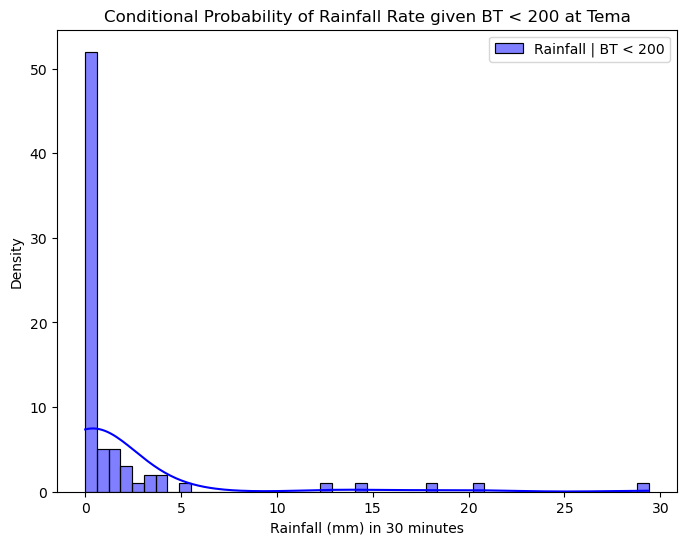

In [17]:
# Define threshold for brightness temperature
threshold = 200

# Filter data where brightness temperature is below the threshold
station_name = 'Tema'  # Example location

df = pd.concat([df_seviri_9[station_name], station_data_gmet_dict[station_name]], join='inner', axis=1)

# Ensure numeric types for comparison
#df[station_name] = pd.to_numeric(df[station_name], errors='coerce')
df['Precipitation (mm)'] = pd.to_numeric(df['Precipitation (mm)'], errors='coerce')

# Drop rows with NaN values after conversion
df = df.dropna()

#df[f'Precipitation (mm)'] = np.log1p(df[f'Precipitation (mm)'])  # log(rainfall + 1)
#plt.plot(sd_normal(df[station_name]), sd_normal(df['Precipitation (mm)']), 'b.')


rainfall_below_threshold = df[df[f'{station_name}'] < threshold][f'Precipitation (mm)']

# Visualization
plt.figure(figsize=(8, 6))
sns.histplot(rainfall_below_threshold, kde=True, color='blue', label=f'Rainfall | BT < {threshold}')
#sns.histplot(df[f'Precipitation (mm)'], kde=True, color='orange', label='All Rainfall Rates', alpha=0.5)

plt.xlabel('Rainfall (mm) in 30 minutes')
plt.ylabel('Density')
plt.title(f'Conditional Probability of Rainfall Rate given BT < {threshold} at {station_name}')
plt.legend()
plt.show()


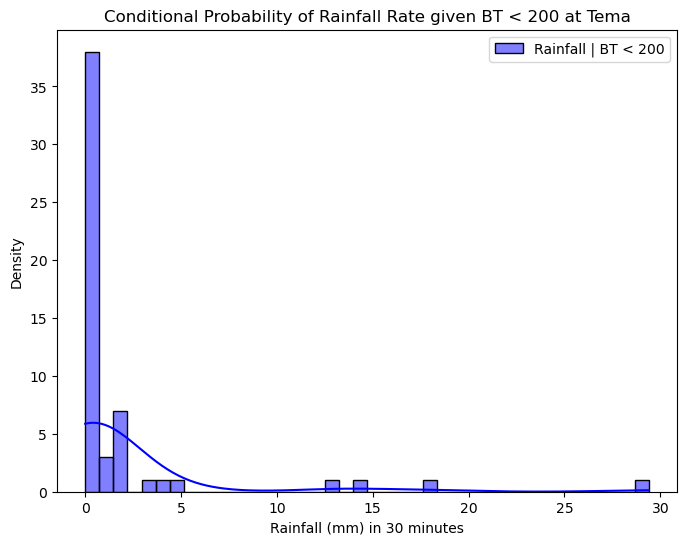

In [18]:
# Define threshold for brightness temperature
threshold = 200

# Filter data where brightness temperature is below the threshold
station_name = 'Tema'  # Example location

df = pd.concat([df_seviri_6[station_name], station_data_gmet_dict[station_name]], join='inner', axis=1)

# Ensure numeric types for comparison
#df[station_name] = pd.to_numeric(df[station_name], errors='coerce')
df['Precipitation (mm)'] = pd.to_numeric(df['Precipitation (mm)'], errors='coerce')

# Drop rows with NaN values after conversion
df = df.dropna()

#df[f'Precipitation (mm)'] = np.log1p(df[f'Precipitation (mm)'])  # log(rainfall + 1)
#plt.plot(sd_normal(df[station_name]), sd_normal(df['Precipitation (mm)']), 'b.')


rainfall_below_threshold = df[df[f'{station_name}'] < threshold][f'Precipitation (mm)']

# Visualization
plt.figure(figsize=(8, 6))
sns.histplot(rainfall_below_threshold, kde=True, color='blue', label=f'Rainfall | BT < {threshold}')
#sns.histplot(df[f'Precipitation (mm)'], kde=True, color='orange', label='All Rainfall Rates', alpha=0.5)

plt.xlabel('Rainfall (mm) in 30 minutes')
plt.ylabel('Density')
plt.title(f'Conditional Probability of Rainfall Rate given BT < {threshold} at {station_name}')
plt.legend()
plt.show()


Abetifi               float64
Precipitation (mm)    float64
dtype: object


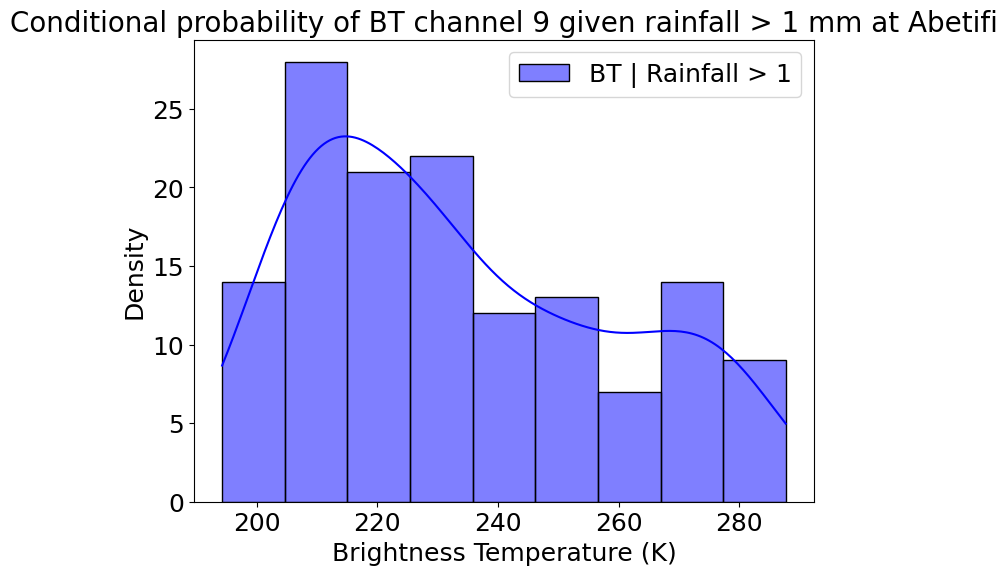

Ada_Foah              float64
Precipitation (mm)    float64
dtype: object


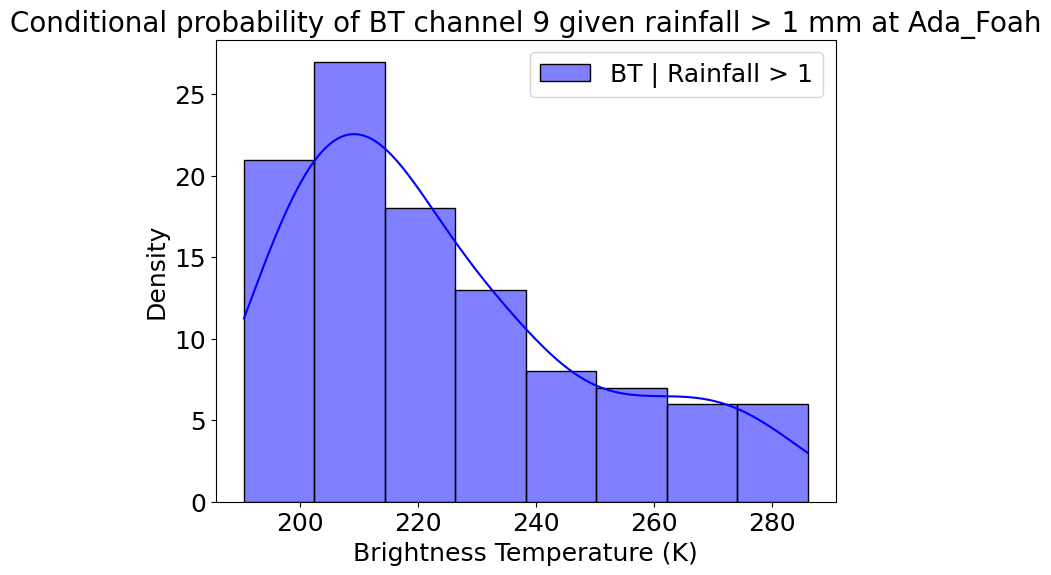

Akim_Oda              float64
Precipitation (mm)    float64
dtype: object


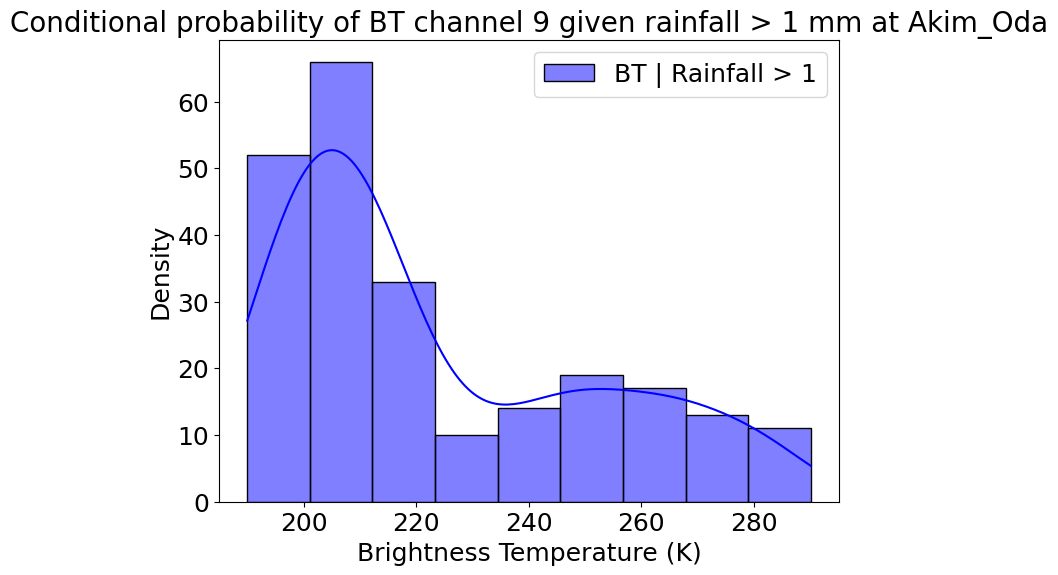

Akosombo              float64
Precipitation (mm)    float64
dtype: object


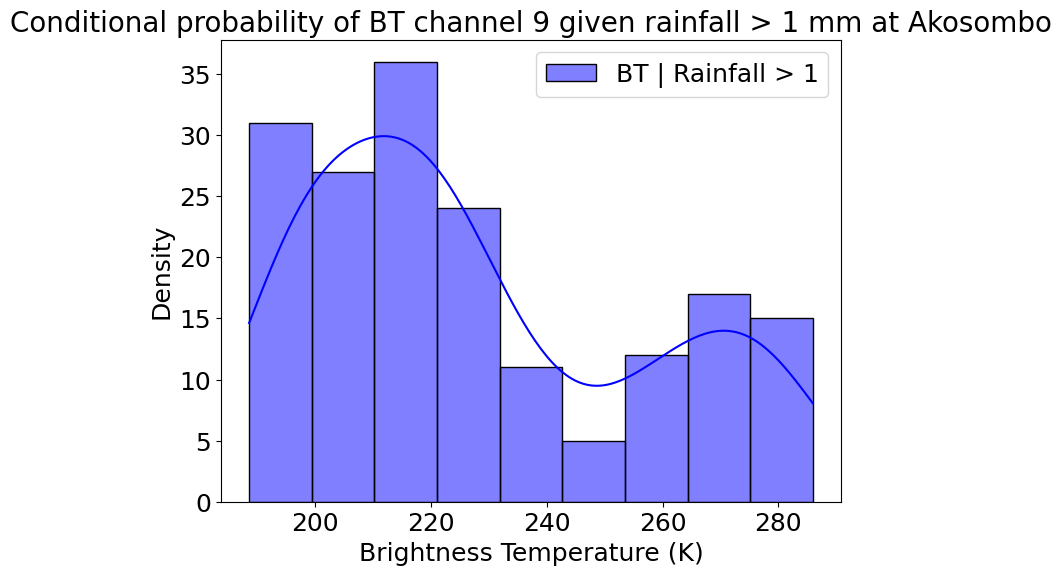

Akuse                 float64
Precipitation (mm)    float64
dtype: object


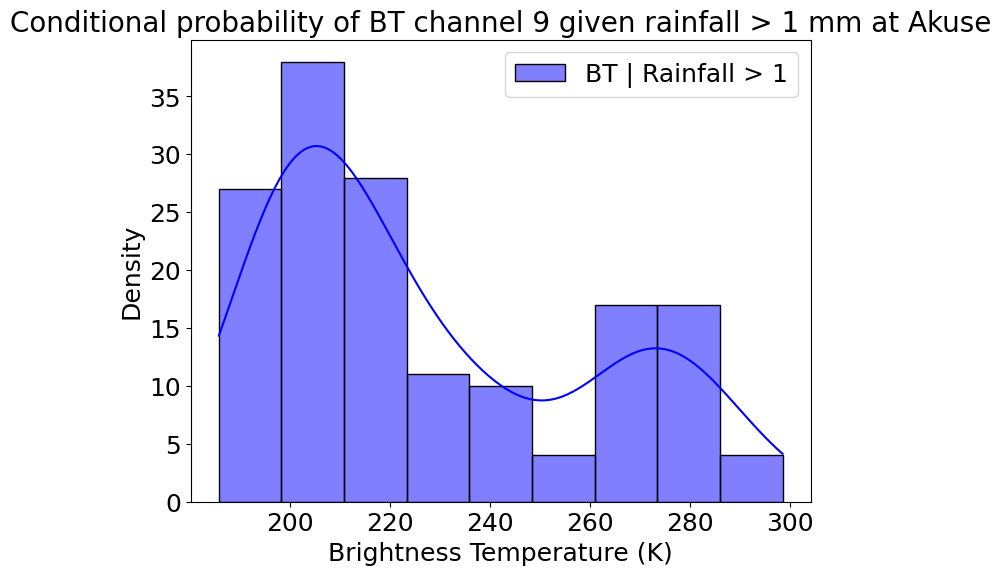

Axim                  float64
Precipitation (mm)    float64
dtype: object


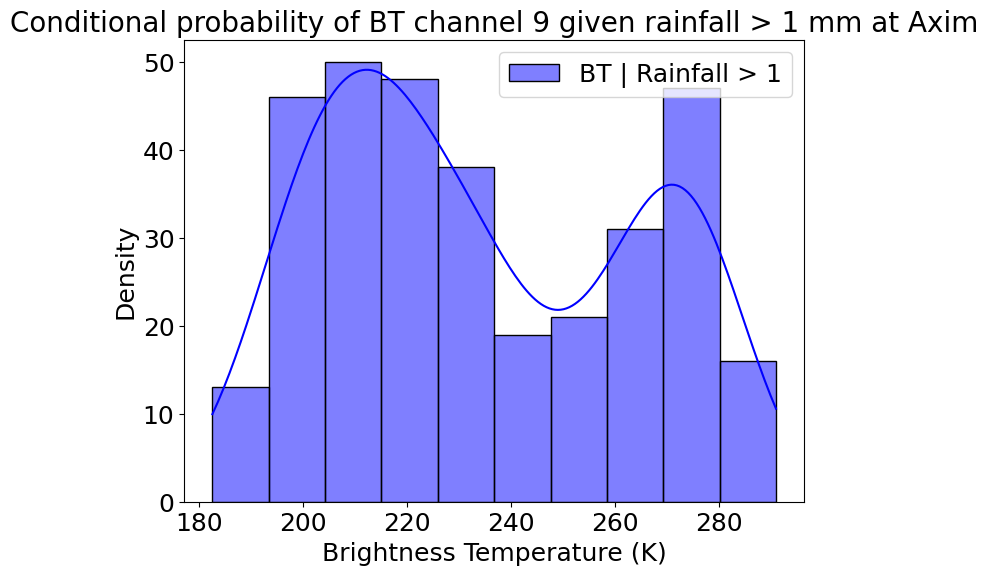

Enchi                 float64
Precipitation (mm)    float64
dtype: object


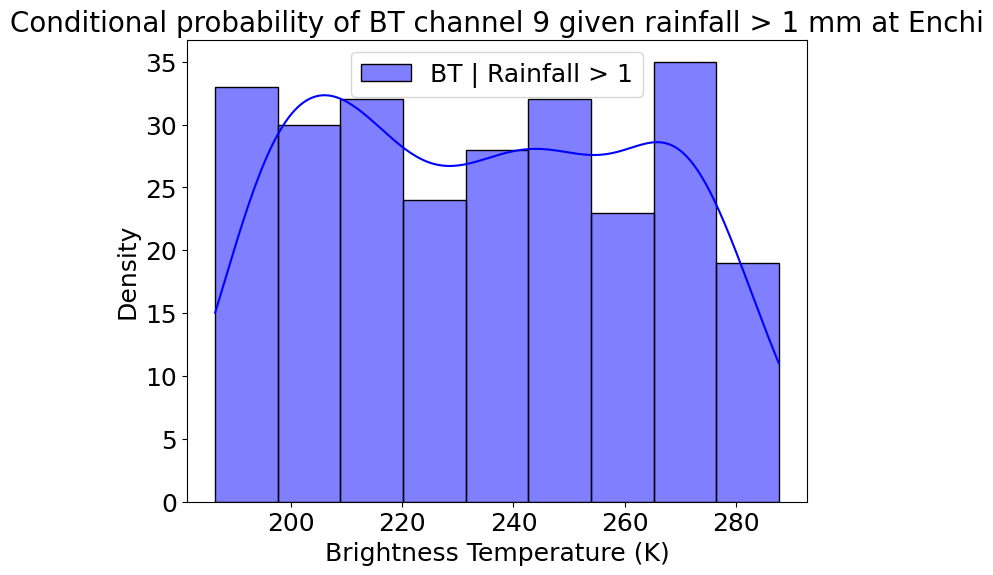

Jirapa                float64
Precipitation (mm)    float64
dtype: object


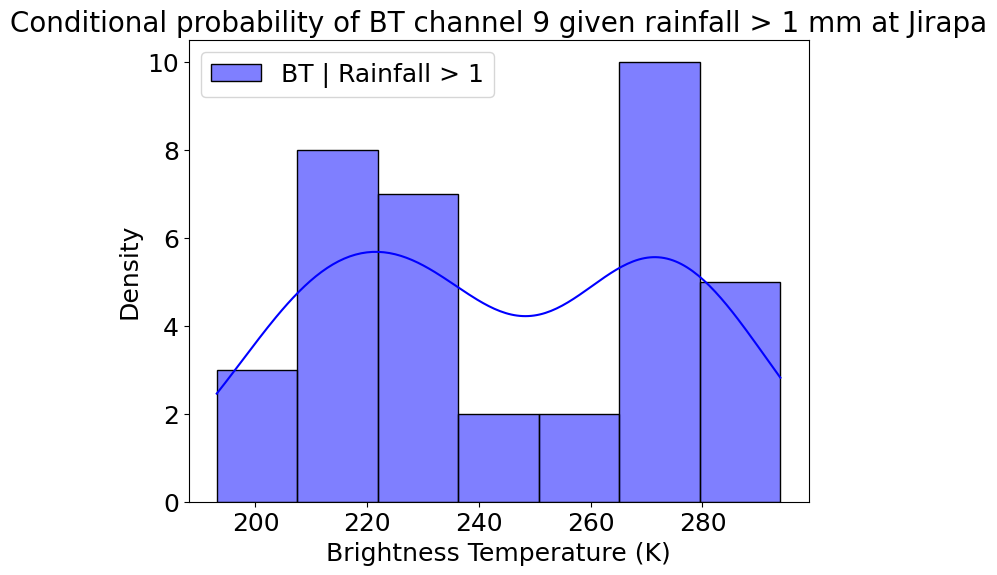

Kalbeo                float64
Precipitation (mm)    float64
dtype: object


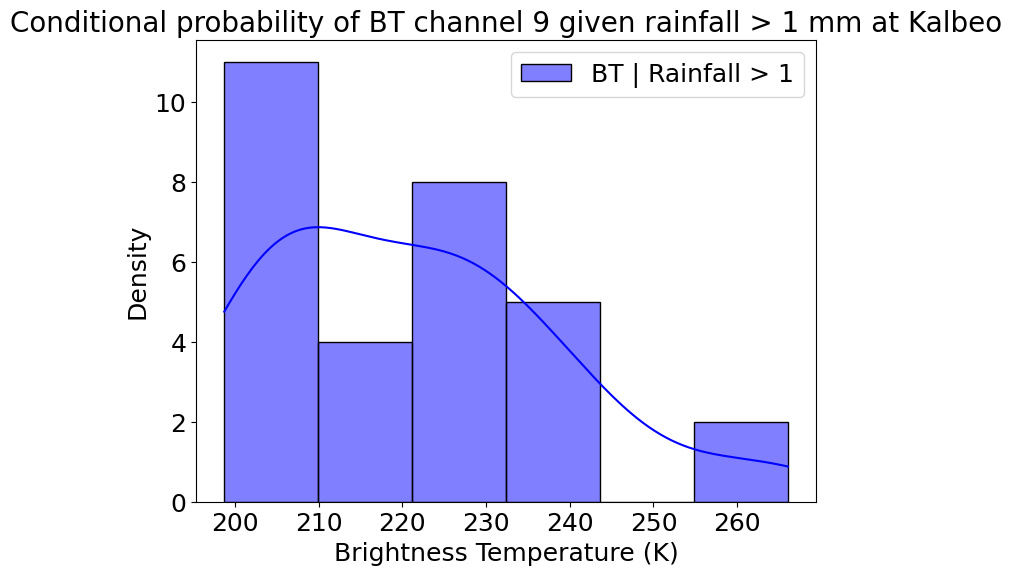

Kpandai               float64
Precipitation (mm)    float64
dtype: object


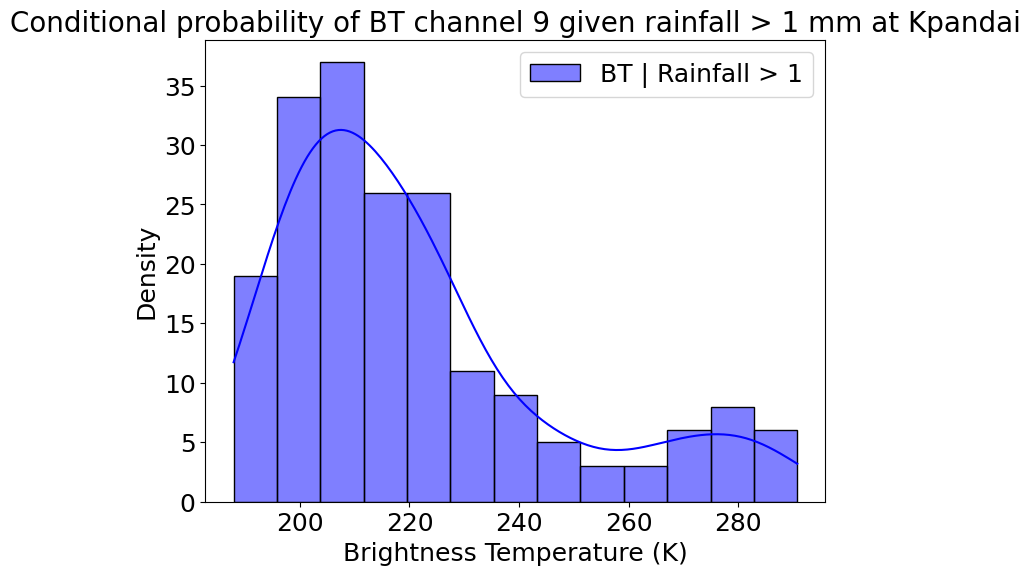

Loagri                float64
Precipitation (mm)    float64
dtype: object


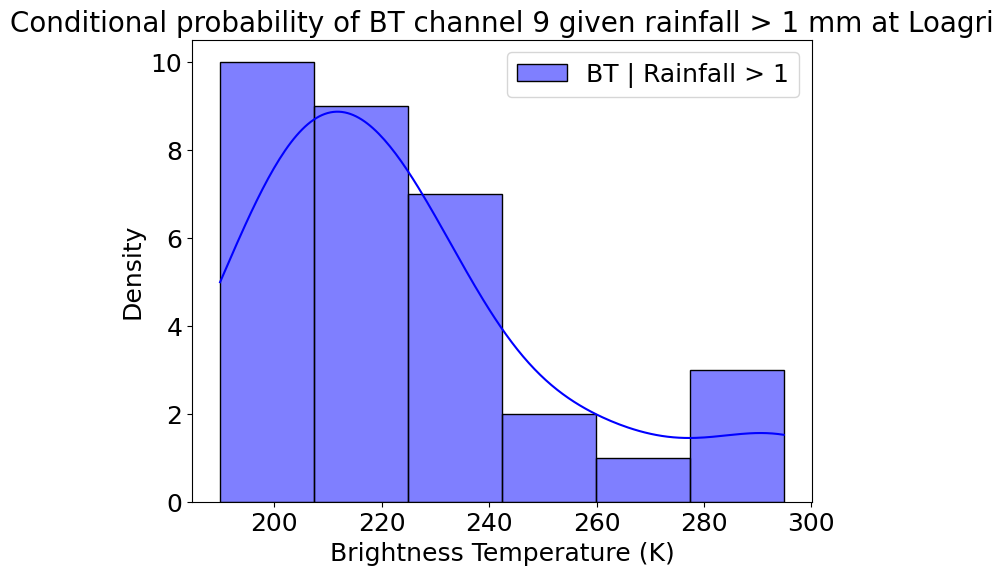

Nakpamboni            float64
Precipitation (mm)    float64
dtype: object


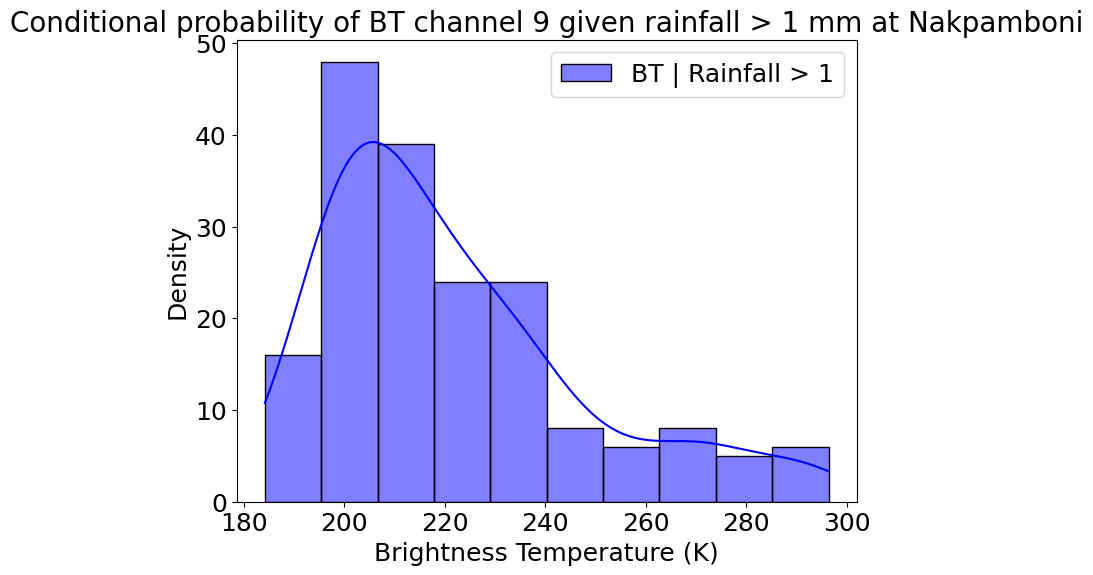

Sefwi_Bekwai          float64
Precipitation (mm)    float64
dtype: object


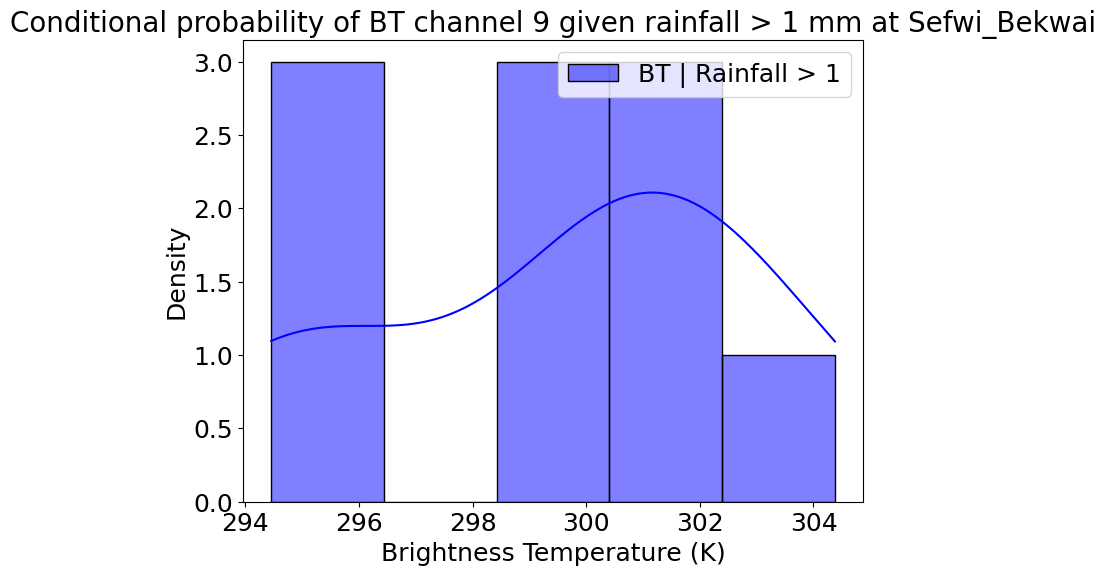

Tarkwa                float64
Precipitation (mm)    float64
dtype: object


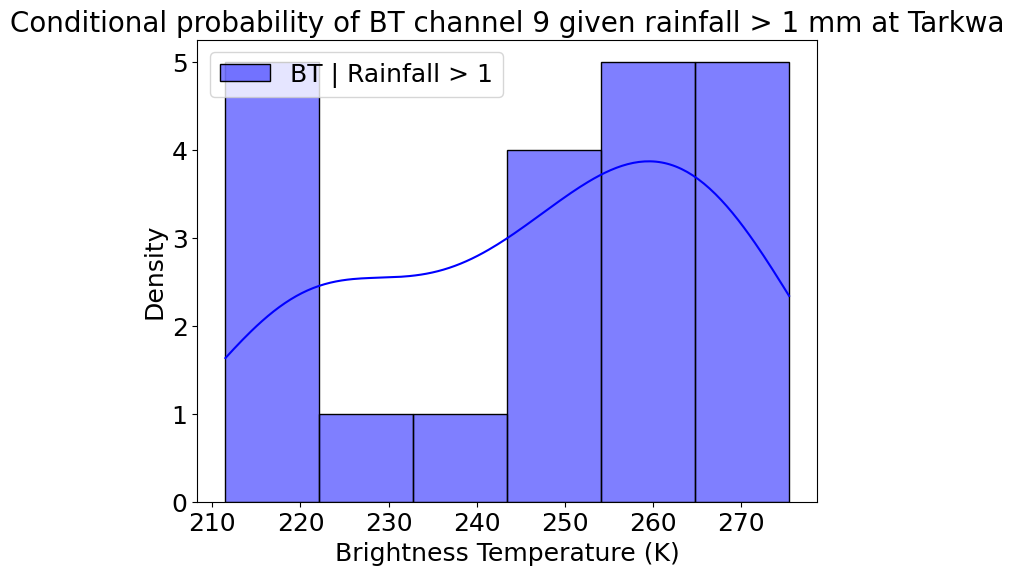

Tema                  float64
Precipitation (mm)    float64
dtype: object


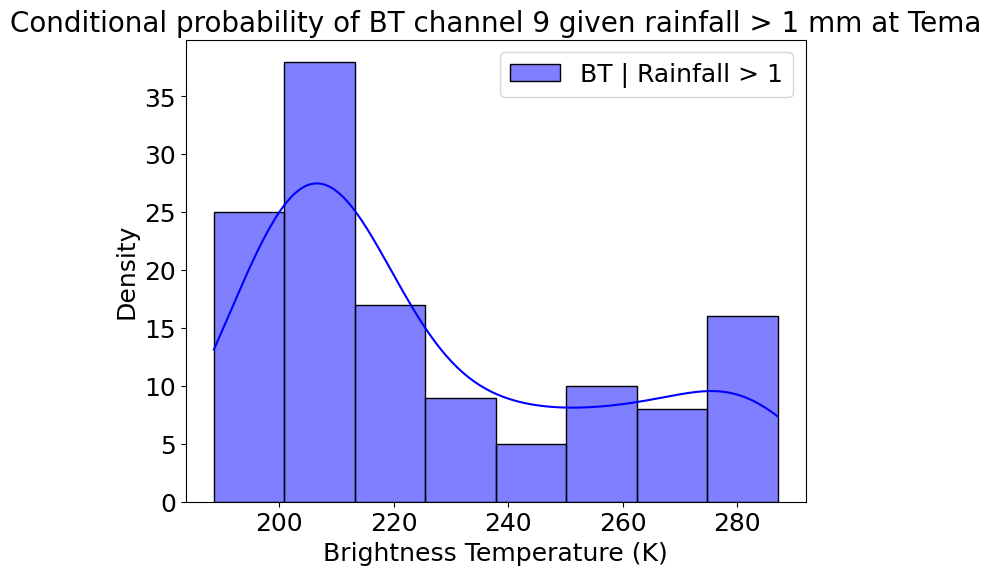

Tolon                 float64
Precipitation (mm)    float64
dtype: object


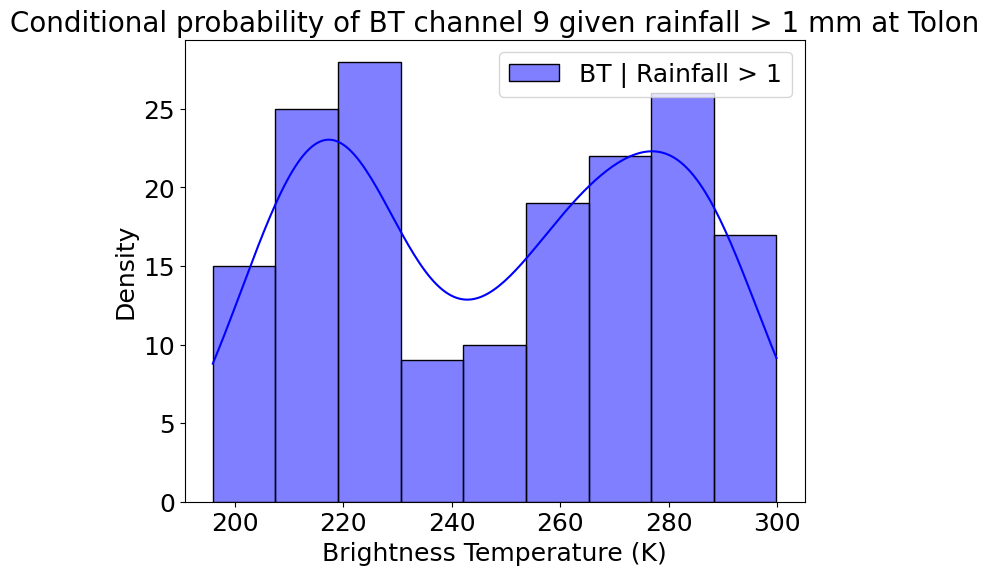

Varenpare             float64
Precipitation (mm)    float64
dtype: object


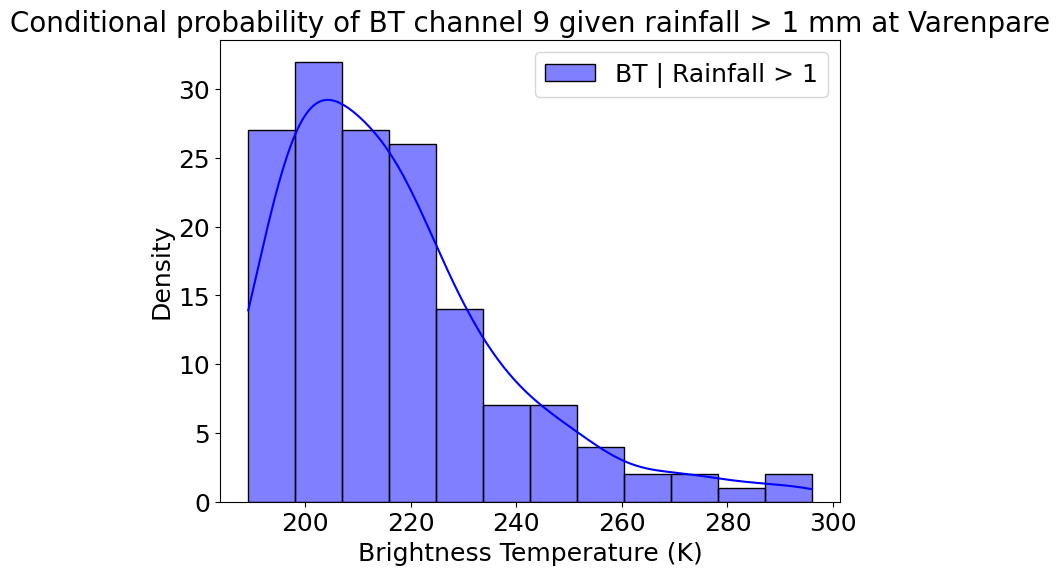

Yendi                 float64
Precipitation (mm)    float64
dtype: object


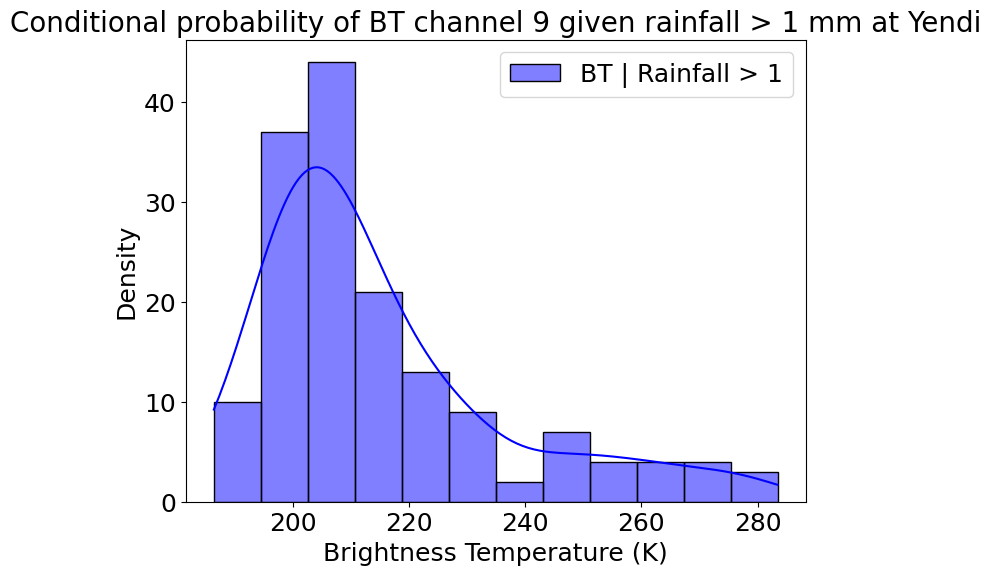

In [24]:
# Define threshold for rainfall (in mm)
threshold = 1

for station_name in station_data_gmet_dict:
# # Example station name
# station_name = 'Varenpare'

    # Combine brightness temperature and rainfall data
    df = pd.concat([df_seviri_9[station_name], station_data_gmet_dict[station_name]], join='inner', axis=1)
    
    # Ensure numeric types and drop NaNs
    df['Precipitation (mm)'] = pd.to_numeric(df['Precipitation (mm)'], errors='coerce')
    df = df.dropna()
    
    print(df.dtypes)
    
    
    # Filter data where rainfall is below the threshold
    bt_given_low_rainfall = df[df['Precipitation (mm)'] > threshold][station_name]
    
    # Visualization
    plt.figure(figsize=(8, 6))
    sns.histplot(bt_given_low_rainfall, kde=True, color='blue', label=f'BT | Rainfall > {threshold}')
    #sns.histplot(df[station_name], kde=True, color='orange', label='All Brightness Temperatures', alpha=0.5)
    
    plt.xlabel('Brightness Temperature (K)', fontsize = 18)
    plt.ylabel('Density', fontsize = 18)
    plt.title(f'Conditional probability of BT channel 9 given rainfall > {threshold} mm at {station_name}', fontsize = 20)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.legend(fontsize = 18)
    plt.savefig(f'Conditional_Probability_threshold_{threshold}_{station_name}.png', bbox_inches = 'tight', dpi = 300)
    plt.show()


In [ ]:
# Example station name
station_name = 'Akuse'

# Combine brightness temperature and rainfall data
df = pd.concat([df_seviri_9[station_name], station_data_gmet_dict[station_name]], join='inner', axis=1)

# Split data into convective and stratiform based on BT
df = df[df['Precipitation (mm)'] > 0.1]

convective_rain = df[df[station_name] < 220]['Precipitation (mm)']
stratiform_rain = df[(df[station_name] >= 260) & (df[station_name] <= 290)]['Precipitation (mm)']

plt.figure(figsize=(8, 6))
sns.histplot(convective_rain, kde=True, color='blue', label='Cold rain processes (BT < 220 K)')
sns.histplot(stratiform_rain, kde=True, color='orange', label='Warm rain processes (260 K < BT < 290 K)', alpha=0.7)

plt.xlabel('Rainfall (mm)')
plt.ylabel('Density')
plt.title('Distribution of rainfall by rainfall process')

plt.legend()
plt.savefig(f'Stratiform_convective_rainfall_{station_name}.png')
plt.show()